In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns
sns.set(style="darkgrid")


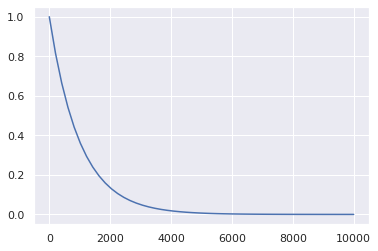

In [2]:
x = np.linspace(0, 10000)
plt.plot(x, 0.999**x)

In [3]:
def reject_outliers_2(data, m=2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    print(d)
    print(mdev)
    print(mdev if mdev else 1.)
    s = d / (mdev if mdev else 1.)
    return data[s < m]

def process_data(env_path):
    data = []
    min_size = np.inf
    for path in glob.glob(env_path + '*/'):
        data_set = pickle.load(open(path + 'reward_data.pkl', 'rb'))
        data_set = np.stack(data_set)
        if data_set[-1,0] < min_size:
            min_size = data_set[-1,0]
        data.append(data_set)
    x_samples = np.linspace(0, min_size)
    interp_data = []
    for data_set in data:
        _x = data_set[:,0]
        _y = data_set[:,1]
        interp_data.append(np.interp(x_samples, _x, _y))

#     _data = np.stack(interp_data)
#     d = np.abs(_data - np.median(_data, axis=0, keepdims=True))
#     mdev = np.median(d, axis=0, keepdims=True)
#     s = d/(mdev if mdev.all() else 1)
#     idxs = s < 2
#     mean = []
#     std  = []
#     for i in range(idxs.shape[1]):
#         mean.append(np.mean(_data[idxs[:,i], i]))
#         std.append(np.std(_data[idxs[:,i], i]))
    
    mean = np.mean(interp_data, axis=0)
    std  = np.std(interp_data, axis=0)
    mean = np.array(mean)
    std = np.array(std)
    data_log = {'x' : x_samples, 'mean' : mean, 'std' : std, 
                'max' : np.max(interp_data, axis=0),
               'min' : np.min(interp_data, axis=0),
               '-std' : mean-std,
               '+std' : mean+std, 'data' : interp_data}
    return data_log

def plot_data(log, label):
    plt.plot(log['x'], log['mean'], label=label)
    plt.fill_between(log['x'], 
                    log['-std'], log['+std'],
                    alpha=0.2)


In [4]:

# hddpg_data = process_data('./benchmarks/data/PendulumEnv/h_ddpg/')
# ddpg_data = process_data('./benchmarks/data/PendulumEnv/ddpg/')
hlt_data = process_data('./benchmarks/data/PendulumEnv/hlt_skill/')
hsac_data = process_data('./benchmarks/data/PendulumEnv/h_sac/')
sac_data = process_data('./benchmarks/data/PendulumEnv/sac/')

plot_data(hlt_data, 'HLT')

plot_data(hsac_data, 'H-SAC')

# plot_data(ddpg_data, 'DDPG')
plot_data(sac_data, 'SAC')


plt.xlabel('time steps')
plt.ylabel('episode total reward')
plt.title('Pendulum Swingup')

plt.legend()



FileNotFoundError: [Errno 2] No such file or directory: './benchmarks/data/PendulumEnv/hlt_skill/2019-12-28_14-54-30/reward_data.pkl'

In [5]:
# hddpg_data = process_data('./benchmarks/data/InvertedPendulumSwingupBulletEnv/h_ddpg/')
# ddpg_data = process_data('./benchmarks/data/InvertedPendulumSwingupBulletEnv/ddpg/')

hlt_data = process_data('./benchmarks/data/InvertedPendulumSwingupBulletEnv/hlt_skill/')


hsac_data = process_data('./benchmarks/data/InvertedPendulumSwingupBulletEnv/h_sac/')
sac_data = process_data('./benchmarks/data/InvertedPendulumSwingupBulletEnv/sac/')

plot_data(hlt_data, 'HLT')
# plot_data(hddpg_data, 'H-DDPG')

plot_data(sac_data, 'SAC')
plot_data(hsac_data, 'H-SAC')

plt.xlabel('time steps')
plt.ylabel('episode total reward')
plt.title('Pendulum Swingup')

plt.legend()

FileNotFoundError: [Errno 2] No such file or directory: './benchmarks/data/InvertedPendulumSwingupBulletEnv/hlt_skill/2019-12-28_18-03-31/reward_data.pkl'

(-400, 200)

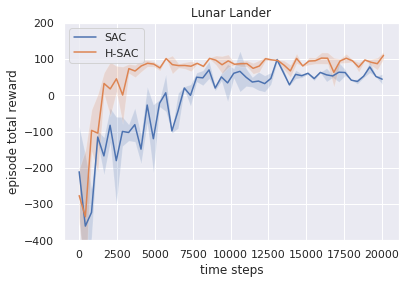

In [508]:
hddpg_data = process_data('./benchmarks/data/LunarLanderContinuousEnv/h_ddpg/')
ddpg_data = process_data('./benchmarks/data/LunarLanderContinuousEnv/ddpg/')

hsac_data = process_data('./benchmarks/data/LunarLanderContinuousEnv/h_sac/')
# hsac_data = process_data('./benchmarks/data/LunarLanderContinuousEnv/h_ddpg/')

sac_data = process_data('./benchmarks/data/LunarLanderContinuousEnv/sac/')

# plot_data(ddpg_data, 'DDPG')
# plot_data(hddpg_data, 'H-DDPG')

plot_data(sac_data, 'SAC')
plot_data(hsac_data, 'H-SAC')


plt.xlabel('time steps')
plt.ylabel('episode total reward')
plt.title('Lunar Lander')

plt.legend()
plt.ylim(-400, 200)

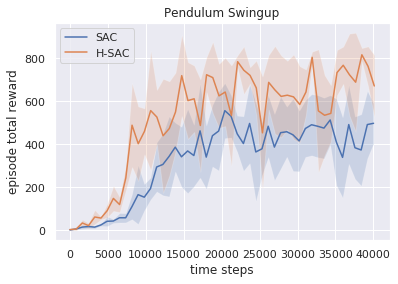

In [509]:
hsac_data = process_data('./benchmarks/data/HopperBulletEnv/h_sac/')
sac_data = process_data('./benchmarks/data/HopperBulletEnv/sac/')
hddpg_data = process_data('./benchmarks/data/HopperBulletEnv/h_ddpg/')
ddpg_data = process_data('./benchmarks/data/HopperBulletEnv/ddpg/')

# plot_data(ddpg_data, 'DDPG')
# plot_data(hddpg_data, 'H-DDPG')

plot_data(sac_data, 'SAC')

plot_data(hsac_data, 'H-SAC')

plt.xlabel('time steps')
plt.ylabel('episode total reward')
plt.title('Pendulum Swingup')

plt.legend()


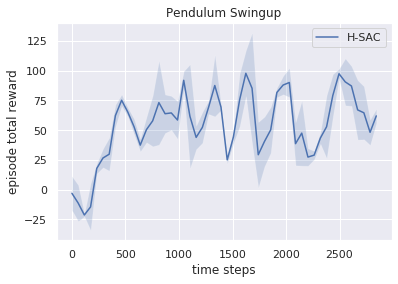

In [496]:
hsac_data = process_data('./benchmarks/data/KukaEnv/h_sac/')
# sac_data = process_data('./benchmarks/data/HopperBulletEnv/sac/')

# plot_data(ddpg_data, 'DDPG')
# plot_data(hddpg_data, 'H-DDPG')

# plot_data(sac_data, 'SAC')
plot_data(hsac_data, 'H-SAC')

plt.xlabel('time steps')
plt.ylabel('episode total reward')
plt.title('Pendulum Swingup')

plt.legend()

In [6]:
import torch

In [7]:
x = torch.randn(10,2, requires_grad=True)

In [16]:
y = x.detach()

In [17]:
y = y + 1.0

In [18]:
x

tensor([[ 0.8698,  0.7042],
        [ 0.1862,  0.6252],
        [ 0.7500,  0.6729],
        [ 1.8120,  0.9259],
        [ 0.7050,  0.0501],
        [-1.4075,  0.9652],
        [-0.2444, -0.2697],
        [ 0.6577, -0.5374],
        [ 0.0069, -0.0144],
        [-0.9087,  2.0609]], requires_grad=True)

In [19]:
y

tensor([[ 1.8698,  1.7042],
        [ 1.1862,  1.6252],
        [ 1.7500,  1.6729],
        [ 2.8120,  1.9259],
        [ 1.7050,  1.0501],
        [-0.4075,  1.9652],
        [ 0.7556,  0.7303],
        [ 1.6577,  0.4626],
        [ 1.0069,  0.9856],
        [ 0.0913,  3.0609]])